# Finding the Least Misfit Functions as an Optimization Problem

In this notebook, we discuss the the optimization procedure used to find the least misfit functions and how they are implemented using the routines in the file `algorithms/core.py`.

As described in the previous notebooks, the upper bound on the error between the DFT based and the FFT based dirty maps depends on the **map error** $\ell(x)$
$$ \ell(x) = \int_0^1\mathrm{d}\nu\, \left| 1 - h(x)\displaystyle\sum_{r=-W/2+1}^{W/2}C_r(\nu)\exp[\mathrm{i}2\pi(r-\nu)x]\right|^2$$
which actually bounds the **square** of the difference between the DFT and FFT based maps once it has been multiplied by $\sum_i w_i|\mathcal{V}(u_i)|^2$. 

We wish to make the map error small over the central region of interest in the map defined as $|x|\leq x_0$. To this end, we define
$$E = \frac{1}{2x_0}\displaystyle\int_{-x_0}^{x_0} \ell(x)\,\mathrm{d}x $$
and seek to minimize $E$ over all choices of $C_r$ and $h$.

For the purposes of the optimization, the continuous variables $\nu$ and $x$ are replaced by values at discrete collections of points, and the integrals approximated. Instead of allowing the values of both $C_r$ and $h$ to vary independently, we can optimize over $C_r$ alone or over $h$ alone since the values of one determine those of the other via the solution of a linear least-squares problem.

In the previous notebook entitled "Evaluating Performance of Gridding and Grid Correction Functions", we found that if $C_r(\nu)$ are given, $\ell(x)$ can be minimized at each $x$ by choosing $h(x)$ appropriately. On the other hand, if $h(x)$ is given, we see that since

$$E = \frac{1}{2x_0}\displaystyle\int_0^1\mathrm{d}\nu\,\int_{-x_0}^{x_0}\mathrm{d}x\, \left| 1 - h(x)\displaystyle\sum_{r=-W/2+1}^{W/2}C_r(\nu)\exp[\mathrm{i}2\pi(r-\nu)x]\right|^2$$ 

$E$ is an integral over $\nu$ of a non-negative integrand, and so will be minimized provided that $C_r(\nu)$ is chosen so as to minimize the following for each $\nu$
$$\int_{-x_0}^{x_0}\mathrm{d}x\, \left| 1 - h(x)\displaystyle\sum_{r=-W/2+1}^{W/2}C_r(\nu)\exp[\mathrm{i}2\pi(r-\nu)x]\right|^2$$ 

Separating out the real and imaginary parts, this is
$$\int_{-x_0}^{x_0}\mathrm{d}x\, \left[\left( 1 - h(x)\displaystyle\sum_{r=-W/2+1}^{W/2}C_r(\nu)\cos[2\pi(r-\nu)x]\right)^2 +
\left(h(x)\displaystyle\sum_{r=-W/2+1}^{W/2}C_r(\nu)\sin[2\pi(r-\nu)x]\right)^2\right]
$$ 

Discretizing the integral by replacing it by a sum over $\mathcal{N}$ sample values $x_i$ distributed over the interval of integration, this may be written as $||\mathbf{d}-\mathbf{B}\mathbf{c}||^2$ where $c_r=C_r(\nu)$,
$$ d_i = \begin{cases}1 & \text{for } 1 \leq i \leq \mathcal{N} \\
    0 & \text{for } \mathcal{N}+1 \leq i \leq 2\mathcal{N}
\end{cases}$$
and
$$
B_{ir} = \begin{cases}
h(x_i)\cos[2\pi(r-\nu)x_i] & \text{for } 1\leq i \leq \mathcal{N} \\
h(x_i)\sin[2\pi(r-\nu)x_i] & \text{for } \mathcal{N}+1 \leq i \leq 2\mathcal{N} \\
\end{cases}
$$
Given $h(x)$, we may thus solve for $C_r(\nu)$ for each $\nu$ using a linear least-squares algorithm such as one based on factorizing $\mathbf{B}$ using the QR algorithm. This turns out to be numerically superior to forming the normal equations which squares the condition number of the problem.

In `algorithms/core.py`, the routine `calc_C` computes the set of optimal gridding convolution functions $C_r(\nu)$ starting from a the gridding correction function $h(x)$ specified on a set of points $x_p=p x_0/N$ for $p=1,...,N.$ The value of $h(0)$ is assumed to be one, which sets the normalization of the problem. A trapezoidal rule approximation for the integral over $x$ is used instead of the sum described above, leading to weights of one half being needed at the endpoints of the interval of integration.

The optimization required to find the samples of $h(x)$ is performed by the Levenberg-Marquardt non-linear least-squares routine `scipy.optimize.leastsq`. This requires the user to provide a function returning a vector whose sum-of-squares is going to be mimimized. The function `func_to_minimize` calculates `loss[p, i, m]` of size $(N+1)\times 2\times M$ such that its sum-of-squares is (proportional to) an approximation to the intergral for $E$. The first index is for the map coordinate $x_p$ over the interval $[0,x_0],$ the second index is zero for the real part and one for the imaginary part of the integrand, and the third index is for the visibility plane coordinate $\nu$ sampled at $M$ equally spaced points in the interval $(0,0.5)$. This objective function is passed to the routine `find_opt_func` which calls `leastsq` to perform the optimization.

The routine `find_opt_func` starts the optimization from an initial guess `h_initial` specified on the $N$ points $x_p$. For small values of $W$ (namely $W=1, 2,3$), it is possible to start with a constant function as the initial guess. However, for larger values of $W$, it is found that the algorithm fails to converge and it is preferable to use an initial guess based on the solutions previously found for $W-1$ and $W-2$.

$$h_{W,\text{initial}}(x) = \frac{h_{W-1,\text{opt}}^2(x)}{h_{W-2,\text{opt}}(x)}$$

We find that this strategy works for values of $W\leq 14$ using double precision arithmetic. It is thus necessary to successively compute the optimal solutions for all values of $W$ up to that which is desired. The following illustrates the computation of the optimal functions up to $W=14$ and places the results in a file for subsequent retrieval. Note that the optimization will take several minutes to complete.

In [1]:
# Imports needed for notebook
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pickle

from algorithms.core import (find_opt_func, calc_C, C_to_grid_correction, 
                             C_to_gridder, calc_map_error_from_C)

In [2]:
x0 = 0.25
M = 32
N = 128

opt_funcs = {}
for W in range(1, 15):
    # The initial guess for h (the gridding correction)
    #  is a constant for W<=3, and is based on the solutions
    #  for lower values of W once W>3
    if W <= 3:
        h_initial = np.ones(N)
    else:
        h_initial = opt_funcs[W-1].h * (opt_funcs[W-1].h/opt_funcs[W-2].h)
    # Perform the optimization for width W, placing the result in opt_funcs[W]
    opt_funcs[W] = find_opt_func(W, x0, N, M, h_initial)

# Save the results in a pickle file
with open("min_misfit_gridding_14.pkl", "wb") as pp:
    pickle.dump(opt_funcs, pp, protocol=-1)

The solution is placed in an object of the `OptFunc` class. This is defined using the `attrs` library (see www.attrs.org), and it contains the attributes `W`, `x_0`, `h` and `M`. The solution of the optimization is in the vector `h` which has $N$ components corresponding to the values of the correction function at the points $x_p=p x_0/N$ for $p=1,...,N.$ The other attributes are copied from the input parameters to `find_opt_func`.

# Calculating the gridding convolution and correction functions from the results of the optimization

Although the raw result of the optimization consists of the gridding correction function $h(x)$ sampled on a coarse grid, we may use this to calculate both the gridding convolution and correction functions on the fine grids required for a typical mapping application.

As stated above, the function `calc_C` uses linear least squares to calculate the values of the $W$ gridding convolution functions $C_r(\nu)$, starting from samples of the gridding correction function. These can be calculated at any value of $\nu$ in the interval $[0,1]$. Since the overall gridding function is even, it is actually sufficient to calculate $C_r(\nu)$ on the interval $[0,\frac{1}{2}]$. 

As described in the previous notebook entitled "Evaluating Performance of Gridding and Grid Correction Functions", we can calculate the gridding correction function $h(x)$ so as to minimize $\ell(x)$, or alternatively as the reciprocal of the Fourier transform of $C(u)$. Again this can be done on an arbitrary collection of points $-\frac{1}{2}\leq x\leq\frac{1}{2}$. This calculation is performed by the function `C_to_grid_correction`.

In [3]:
# Load prcomputed optimal functions from file. Run this cell to avoid 
#  repeating the time-consuming optimization in the previous cell.
with open("min_misfit_gridding_14.pkl", "rb") as pp:
    opt_funcs = pickle.load(pp)

<IPython.core.display.Javascript object>


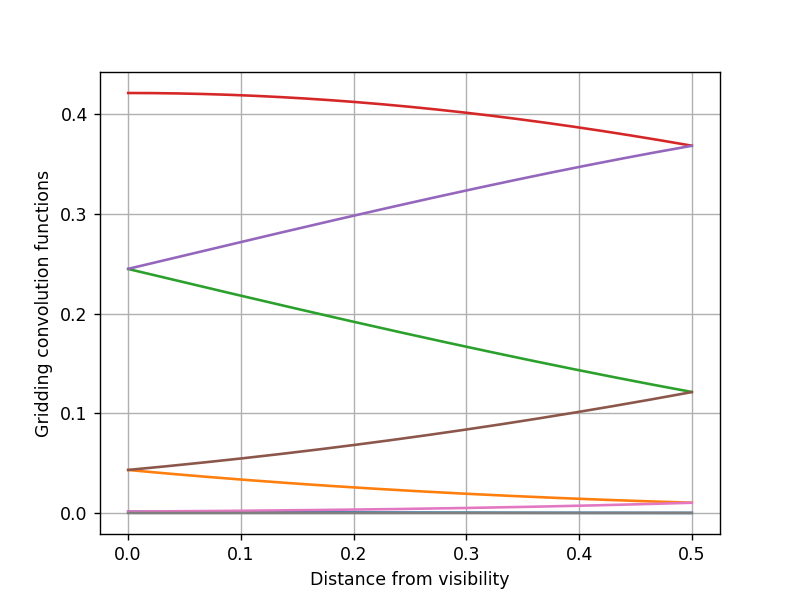

<IPython.core.display.Javascript object>


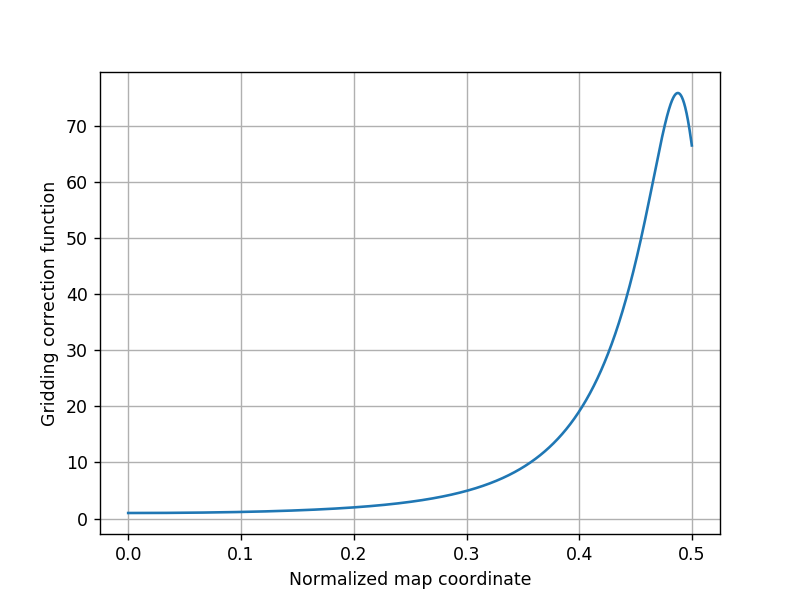

Text(0, 0.5, 'Gridding correction function')

In [4]:
opt = opt_funcs[8]

M = 1024
nu_C = (np.arange(M) + 0.5)/(2*M)
N = 2048
x = np.arange(N)/(2*N)

C = calc_C(opt.h, opt.x0, nu_C, opt.W)
correction = C_to_grid_correction(C, nu_C, x, optimal=True)

plt.figure()
plt.plot(nu_C, C.transpose())
plt.grid(True)
plt.xlabel("Distance from visibility")
plt.ylabel("Gridding convolution functions")

plt.figure()
plt.plot(x, correction)
plt.grid(True)
plt.xlabel("Normalized map coordinate")
plt.ylabel("Gridding correction function")

The $W$ gridding convolution functions $C_r(\nu)$ may be reformatted as the single function $C$ defined on the interval $[-W/2,W/2]$ where $C_r(\nu)=C(r-\nu)$. This may be done with the function `C_to_gridder`.

<IPython.core.display.Javascript object>


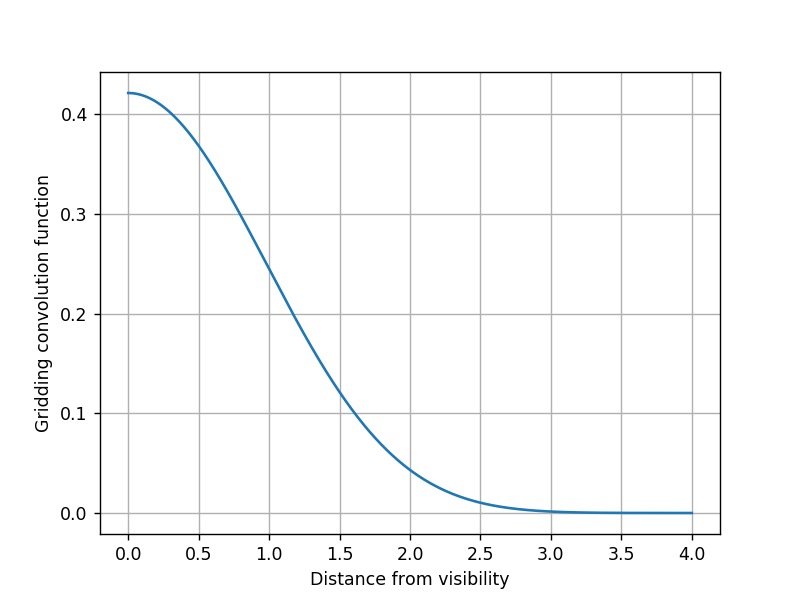

Text(0, 0.5, 'Gridding convolution function')

In [5]:
plt.figure()
plt.plot((np.arange(opt.W*M) + 0.5)/(2*M), C_to_gridder(C))
plt.grid(True)
plt.xlabel("Distance from visibility")
plt.ylabel("Gridding convolution function")

# Calculating the Map Error $\ell(x)$

The map error may be computed using the function `calc_map_error_from_C`. This is illustrated below:

<IPython.core.display.Javascript object>


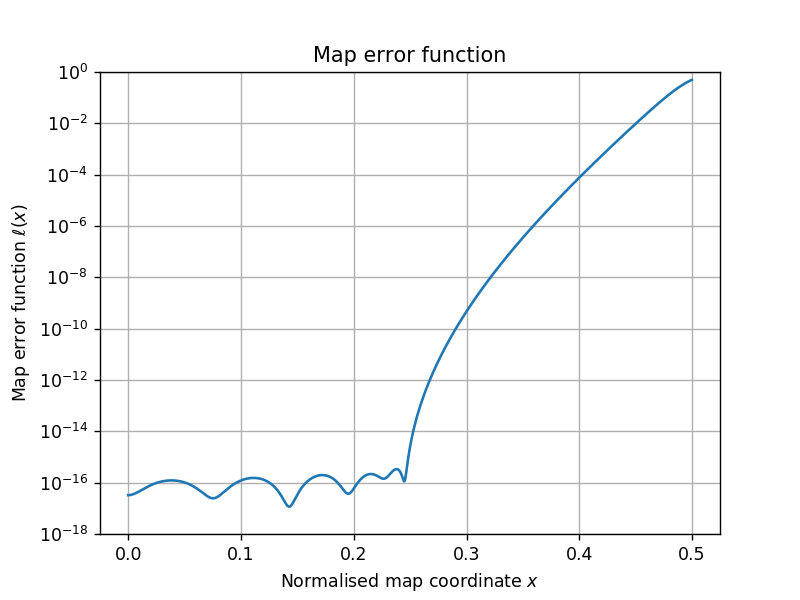

In [6]:
ell = calc_map_error_from_C(C, correction, nu_C, x, opt.W)

plt.figure()
plt.semilogy(x, ell)
plt.ylim(1.0e-18, 1.0)
plt.title('Map error function')
plt.xlabel('Normalised map coordinate $x$')
plt.ylabel('Map error function $\\ell(x)$')
plt.grid(True)

# Map error for least misfit functions with $x_0=0.25$, $W=1,...,14$

<IPython.core.display.Javascript object>


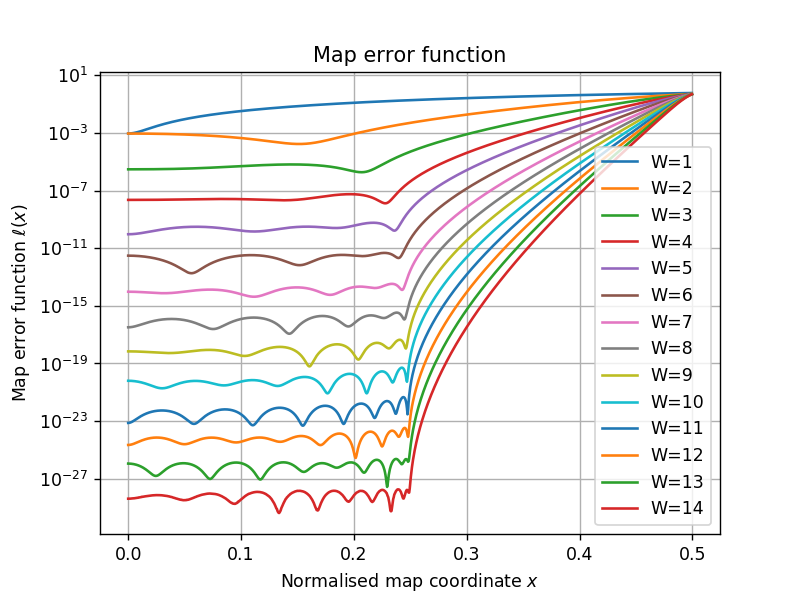

In [7]:
M = 64
nu_C = (np.arange(M) + 0.5)/(2*M)
N = 1024
x = np.arange(N)/(2*N)

plt.figure()

for i, opt in opt_funcs.items():
    C = calc_C(opt.h, opt.x0, nu_C, opt.W)
    correction = C_to_grid_correction(C, nu_C, x, optimal=True)
    ell = calc_map_error_from_C(C, correction, nu_C, x, opt.W)
    plt.semilogy(x, ell, label="W=%d" % opt.W)
    
plt.title('Map error function')
plt.xlabel('Normalised map coordinate $x$')
plt.ylabel('Map error function $\\ell(x)$')
plt.grid(True)
plt.legend()

In this notebook we have used the low-level functions to calculate the convolutional gridding, gridding correction and map error functions from the results of the optimization used to find the least misfit gridding functions. In the previous notebooks, we have used functions such as `calc_gridder`, `gridder_to_grid_correction` and `calc_map_error` which are thin wrappers around the low-level functions. These wrapper functions are convenient for working directly with the convolution function $C$ rather than the $W$ separate functions $C_r$ and are also useful when analyzing the performance of other convolutional gridding functions which are in current use.